In [1]:
import sklearn.ensemble as sken
import astropy.table as atpy
import numpy as np
import sklearn.model_selection as skmose 
import ephem
import astropy.time
import matplotlib.pyplot as plt
import healpy
import sphdist


In [2]:
#fname,format = 'des-moon-sky-t_fix.csv','ascii'

# read the input file

fname,format = 'DECam_sky.fits',None
tab = atpy.Table().read(fname,format=format)
tab =  tab[np.random.permutation(len(tab))]
# permute just in case


In [7]:
# Compute some extra stuff (compute asimuths, zd of moon, sun and targets)

sun = ephem.Sun()
moon = ephem.Moon()
obs = ephem.Observer()
body = ephem.FixedBody()
body._epoch=2000

# Blanco 
obs.lon='-70:47:23.49' # E+
obs.lat='-30:10:10.78' # N+
times = astropy.time.Time(tab['mjd'],format='mjd')
xdates =[_.datetime.strftime('%Y/%m/%d %H:%M:%S') for _ in times]

moonP = []
moonAlt = []
sunAlt = []
objAlt = []
objAz = []
sunAz = []
moonAz = []

for ra, dec, x in zip(tab['ra'],tab['dec'],xdates):
        obs.date = x
        body._ra = np.deg2rad(ra)
        body._dec = np.deg2rad(dec)
        moon.compute(obs)
        sun.compute(obs)
        body.compute(obs)

        moonAlt.append(np.rad2deg(moon.alt))
        moonAz.append(np.rad2deg(moon.az))
        moonP.append(moon.phase)

        sunAlt.append(np.rad2deg(sun.alt))
        sunAz.append(np.rad2deg(sun.az))

        objAlt.append(np.rad2deg(body.alt))      
        objAz.append(np.rad2deg(body.az))

sunAlt, moonP, moonAlt, objAlt, moonAz, sunAz, objAz = [np.array(_) for _ in [
                sunAlt, moonP, moonAlt, objAlt, moonAz, sunAz, objAz]]

In [5]:
# Preparation of input data
indat = np.array([tab['trans'], tab['zd'],tab['moonSep'],
                tab['moonPhase'],tab['moonZD']])

outdat = np.log10(tab['sky'])

/home/koposov/pyenv3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/koposov/pyenv3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


In [8]:
maxSunAlt = -18 # maximum altitude of the Sun

goodset= ( np.isfinite(indat).all(axis=0) &
        (sunAlt < maxSunAlt) &
        np.isfinite(outdat))

def fitmodel(filt, sub = None):
    rfr = sken.RandomForestRegressor()
    gsrfr = skmose.GridSearchCV(rfr, {'n_estimators':[10,30,100,300],
                        'min_samples_split':[2,10,30,100]},
                n_jobs=8, cv=3)

    xind = (tab['band'] == filt) & goodset
    if sub is not None:
        xind = xind & sub
    indatF = indat[:,xind]
    outdatF = outdat[xind]
    gsrfr.fit(indatF.T, outdatF)
    return gsrfr


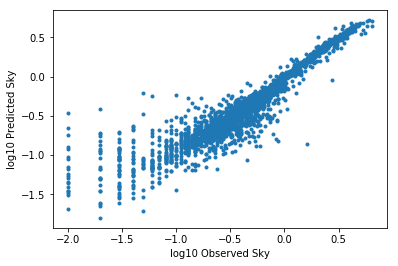

In [9]:
# fit the model on 90%
frac  = 0.9
sub = np.random.uniform(size=len(tab)) < frac
modelR0 = fitmodel(2, sub)
# predict on the rest of 10%
indatC = indat[:,goodset & (tab['band'] == 2) & (~sub)]
outdatC = outdat[goodset & (tab['band'] == 2) & (~sub)]
predC = modelR0.predict(indatC.T)
plt.plot(outdatC, predC, '.')
plt.xlabel('log10 Observed Sky')
plt.ylabel('log10 Predicted Sky')


In [10]:
modelG = fitmodel(1)
modelR = fitmodel(2)
modelI = fitmodel(3)
#background models in different bands


In [11]:
def make_simulation(modeler, filt, N, minMoonDist= 35):
    # simulate the sky levels
    
    minAlt = 30
    # minimum altitude of objects above the horizon 
    # This should really come from the survey simulation as this is pure geometry.
    sun = ephem.Sun()
    moon = ephem.Moon()
    obs = ephem.Observer()
    body = ephem.FixedBody()
    body._epoch = 2000

    # Kitt Peak
    obs.lon = '-111:47:23.49' # E+
    obs.lat =  '31:10:10.78'   # N+


    # random dates across the year
    mjds = np.random.uniform(58000, 60000, size=10*N)
    times = astropy.time.Time(mjds, format='mjd')
    xdates = np.array([_.datetime.strftime('%Y/%m/%d %H:%M:%S') for _ in times])

    moonP = []
    moonAz = []
    moonAlt = []
    sunAz = []
    sunAlt = []
    objAz = []
    objAlt = []

    for x in (xdates):
        obs.date = x
        moon.compute(obs)
        sun.compute(obs)

        moonAz.append(np.rad2deg(moon.az))
        moonAlt.append(np.rad2deg(moon.alt))
        moonP.append(moon.phase)

        sunAz.append(np.rad2deg(sun.az))
        sunAlt.append(np.rad2deg(sun.alt))

    sunAlt, moonP, moonAlt, moonAz, sunAz = [np.array(_) for _ in [
                sunAlt, moonP, moonAlt, moonAz, sunAz]]
    
    moonP = np.rad2deg(np.arccos(2*moonP/100.-1))
    # convert moonphases (0-100%) to angle in degrees
    
    xind = (moonAlt > 0) & ( moonP < 90) & (sunAlt < maxSunAlt)
    # select the time when moon is above the horizon, it is not twilight and 
    # moon is bright ( < 90deg)
 
    xdates = xdates[xind]
    sunAlt, moonP, moonAlt, moonAz, sunAz = [_[xind] for _ in [
                sunAlt, moonP, moonAlt, moonAz, sunAz]]


    # create fake population of targets 
    # that are uniformly distributed on the sky such that they have
    # altitude above minAlt
    # and the moon distance > minMoonDist

    for curmoonAz, curmoonAlt in zip(moonAz, moonAlt):
        # uniform distribution on the sky with Alt > minAlt
        while True:
            Az = np.random.uniform(0, 360)
            Alt = np.rad2deg(np.arcsin(np.random.uniform(np.sin(np.deg2rad(minAlt)), 1)))
            if sphdist.sphdist(Az, Alt, curmoonAz, curmoonAlt) > minMoonDist:
                break
        objAlt.append(Alt)
        objAz.append(Az)
    objAlt = np.array(objAlt)
    objAz = np.array(objAz)
    
    moonD = sphdist.sphdist(objAz, objAlt, moonAz, moonAlt)
    # distance from the objects to the moon 
    
    #take random samples of transparencies the past
    curtrans = tab['trans'][tab['band'] == filt]
    simtrans = curtrans[np.random.randint(0,len(curtrans),size=len(moonD))]
    
    indat = np.array([simtrans, 90 - objAlt, moonD, moonP, 90 - moonAlt])
    simsky = 10 ** modeler.predict(indat.T)
    return simsky


In [12]:
simskyG = make_simulation(modelG, 1, 10000)
simskyR = make_simulation(modelR, 2, 10000)
simskyI = make_simulation(modelI, 3, 10000)
simskyG20 = make_simulation(modelG, 1, 10000, minMoonDist=20)


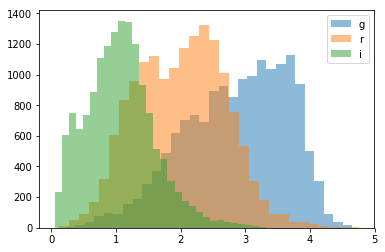

In [16]:
_=plt.hist(simskyG, bins=30, alpha=0.5, label='g')
_=plt.hist(simskyR, bins=30, alpha=0.5, label='r')
_=plt.hist(simskyI, bins=30, alpha=0.5, label='i')
plt.legend()

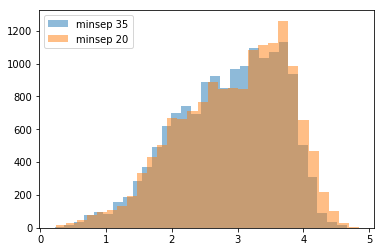

In [15]:
plt.hist(simskyG,bins=30,label='minsep 35',alpha=0.5)
plt.hist(simskyG20,bins=30,label='minsep 20',alpha=0.5)
plt.legend()